# Setup

In [7]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
import numbers
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps  

# Generate Parameters

In [8]:
def generate_parameters(n,rewiring_type='hierarchical'):
    params_list = []
    print('Generating parameters...')
    for _ in tqdm(range(n)):
        n_agents = random.randint(10, 500)
        ba_degree = random.randint(1, int(n_agents/10))
        er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical':
            G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G_er, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            G_ba = nx.barabasi_albert_graph(n_agents, ba_degree)
            network = randomize_network_v2(G_ba, p_rewiring=p_rewiring)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.01)
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "ba_degree": ba_degree,
            "er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [9]:
# Example usage
parameter_dictionaries = generate_parameters(2,rewiring_type='randomize')  # Generate parameter dictionaries
parameter_dictionaries

Generating parameters...


100%|██████████| 2/2 [00:00<00:00, 32.07it/s]


[{'n_agents': 408,
  'ba_degree': 11,
  'er_prob': 0.20427529314863177,
  'p_rewiring': 0.13630972073440117,
  'network': <networkx.classes.graph.Graph at 0x7f8565b25c60>,
  'uncertainty': 0.0027366432651975076,
  'n_experiments': 962,
  'rewiring_type': 'randomize',
  'mean_degree': 21.25980392156863},
 {'n_agents': 286,
  'ba_degree': 10,
  'er_prob': 0.06130758006202314,
  'p_rewiring': 0.6491449598195368,
  'network': <networkx.classes.graph.Graph at 0x7f855ff1a800>,
  'uncertainty': 0.00509914597201201,
  'n_experiments': 350,
  'rewiring_type': 'randomize',
  'mean_degree': 18.895104895104897}]

# Simulation Functions

In [10]:
def run_simulation_with_params(param_dict, number_of_steps=200, agent_type="bayes"):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    df = pd.DataFrame(my_model.agents_choices) 
    result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    
    return result_dict


def run_simulations(param_list, number_of_steps=1000,agent_type="bayes"):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run Simulations

In [11]:
# Test Simulation
parameter_dictionaries = generate_parameters(2,rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=500, agent_type="bayes")
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Generating parameters...


Running simulations: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,true_consensus_alternative_stop,choice_consensus,convergence_step,agent_type
0,498,2,0.033734,0.884410,0.006184,804,randomize,3.983936,0.991968,0.991968,0.991968,70,bayes
1,96,7,0.092726,0.876095,0.006809,699,randomize,12.375000,1.000000,1.000000,1.000000,12,bayes


In [12]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 10 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 500 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_results_df.csv', index=False)
    
bayes_results_df.info()

Generating parameters...


  2%|▏         | 11/500 [01:18<36:38,  4.50s/it] 

In [ ]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="beta")
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betaagent_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 10 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="beta")
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betaagent_results_df.csv', index=False)

beta_results_df.info()

Generating parameters...


  0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Generating parameters...


Running simulations: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         6 non-null      object 
 1   ba_degree                        6 non-null      object 
 2   er_prob                          6 non-null      float64
 3   p_rewiring                       6 non-null      float64
 4   uncertainty                      6 non-null      float64
 5   n_experiments                    6 non-null      object 
 6   rewiring_type                    6 non-null      object 
 7   mean_degree                      6 non-null      float64
 8   true_consensus                   6 non-null      float64
 9   true_consensus_alternative_stop  6 non-null      object 
 10  choice_consensus                 6 non-null      float64
 11  convergence_step                 6 non-null      object 
 12  agent_type                

# Now Some Plotting

## Basic Plotting

In [ ]:
def plot_results(results_df=results_df,variable_of_interest = 'true_consensus'):
    grouped = results_df.groupby(['rewiring_type', 'n_agents'])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(10, 8))

    for rewiring_type in results_df['rewiring_type'].unique():
        subset = grouped[grouped['rewiring_type'] == rewiring_type]
        plt.plot(subset['n_agents'], subset[variable_of_interest], marker='o', label=rewiring_type)

    plt.xlabel('Number of Agents')
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by Number of Agents and rewiring_type')
    opinionated.add_legend(title='rewiring_type')

    plt.grid(True)
    plt.show()

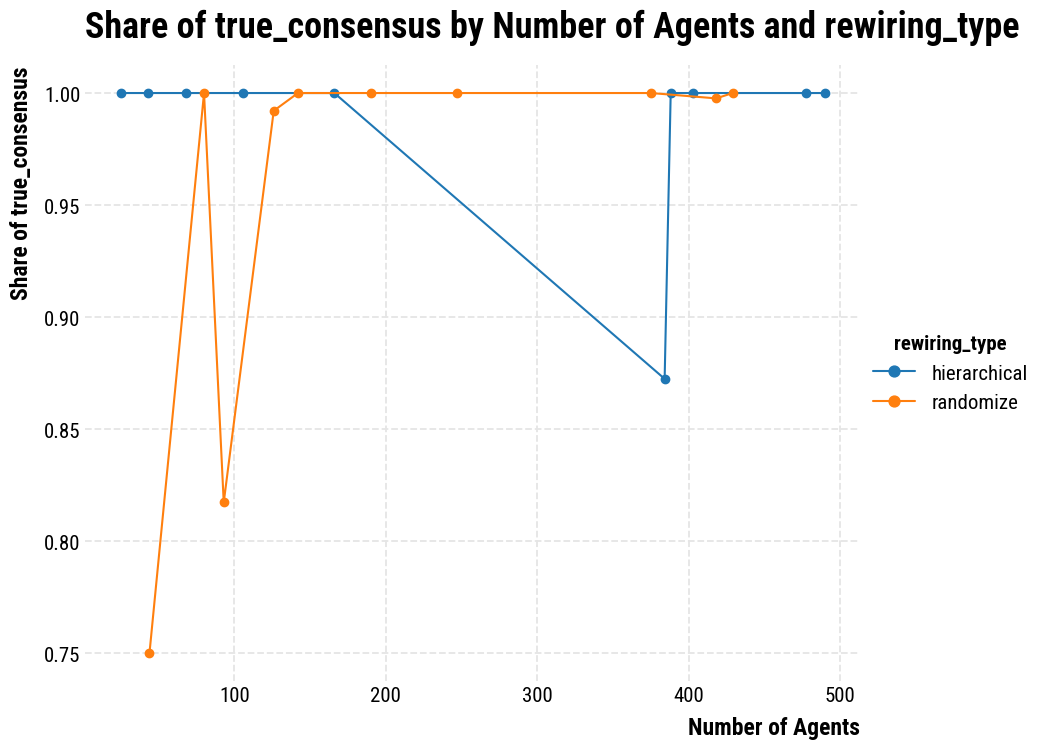

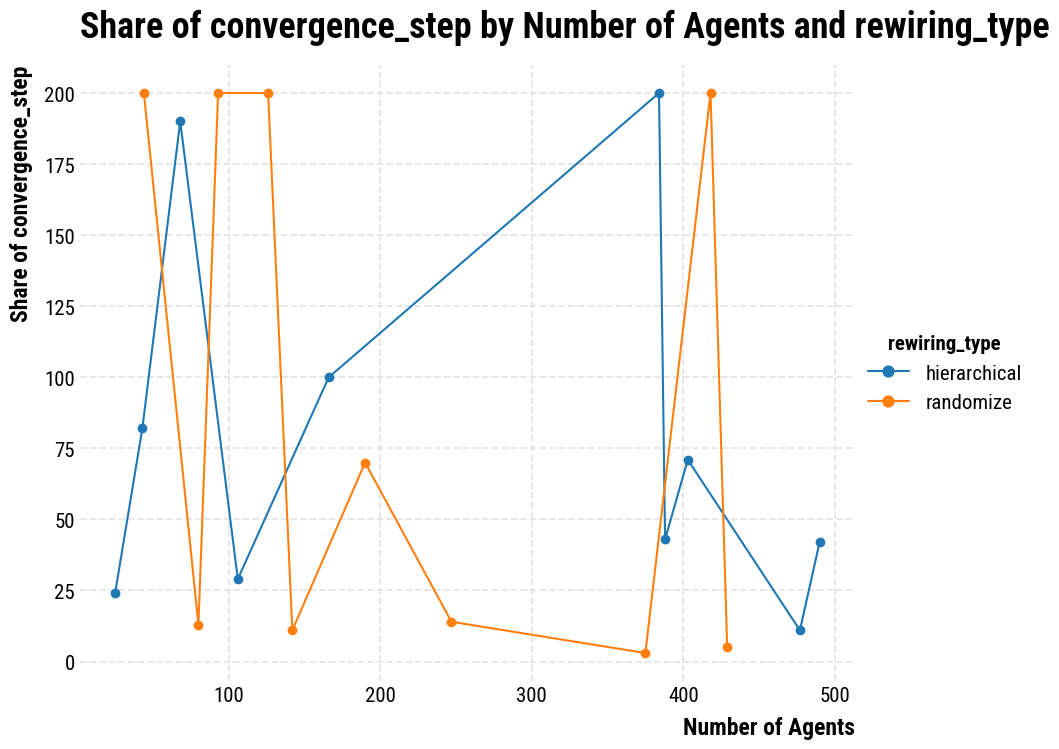

In [ ]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step')

# More Advanced Plotting

In [ ]:
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split

In [ ]:
bayes_results_df.head()

,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,true_consensus_alternative_stop,choice_consensus,convergence_step,agent_type
0,388,27,0.212329,0.285187,0.002063,324,hierarchical,164.046392,1.000000,1.0,1.000000,43,bayes
1,68,1,0.256861,0.784126,0.002188,167,hierarchical,34.117647,1.000000,1.0,1.000000,190,bayes
2,25,2,0.221987,0.649567,0.006193,613,hierarchical,11.280000,1.000000,1.0,1.000000,24,bayes
3,384,37,0.255654,0.127755,0.001883,17,hierarchical,196.406250,0.872396,False,0.859375,200,bayes
4,106,9,0.194228,0.385930,0.005938,329,hierarchical,39.603774,1.000000,1.0,1.000000,29,bayes


## First Just on Number of Agents

In [ ]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

In [ ]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

Model for hierarchical:
Accuracy on training data: 0.8571428571428571
Accuracy on test data: 1.0
------------------------------
Model for randomize:
Accuracy on training data: 0.7142857142857143
Accuracy on test data: 0.3333333333333333
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


({'hierarchical': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False),
  'randomize': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False)},
     n_agents  uncertainty  p_rewiring  mean_degree
 10       142     0.007550    0.100761    23.281690
 11       190     0.008980    0.756384    26.442105
 12        44     0.002884    0.916358     1.863636
 13       375     0.009186    0.710161    49.413333
 14        80     0.006021    0.951762    13.600000
 15       418     0.001480    0.643086    53.401914
 16       247     0.004531    0.791867    35.133603
 17       126     0.001993    0.259938    11.142857
 18        93     0.003651    0.443580    15.311828
 19       429     0.008139    0.196564    52.997669)

In [ ]:
X.head()

,n_agents,uncertainty,p_rewiring,mean_degree
10,142,0.007550,0.100761,23.281690
11,190,0.008980,0.756384,26.442105
12,44,0.002884,0.916358,1.863636
13,375,0.009186,0.710161,49.413333
14,80,0.006021,0.951762,13.600000


In [ ]:
def plot_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    my_gams,X = do_regression(results_df=results_df,variable_of_interest = variable_of_interest)
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    cmap= cmaps.colorblind_10

    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)

    colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

    for i, (network_type, gam) in enumerate(my_gams.items()):
        conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
        plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


    for i, (network_type, gam) in enumerate(my_gams.items()):
        # Generating a range of values for n_agents to predict and plot
        # Predicting with the model
        #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
        y_pred = gam.predict_proba(X_range.reshape(-1, 1))

        # Plotting predicted probabilities
        plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
        
    # Adding title, labels, and legend
    plt.title('Effect of n_agents on '+ variable_of_interest +' Probability')
    plt.xlabel('Number of Agents')
    plt.ylabel('Probability of ' +variable_of_interest)
    plt.legend()
    plt.show()

In [ ]:
plot_regression(bayes_results_df)

Model for hierarchical:
Accuracy on training data: 0.8571428571428571
Accuracy on test data: 1.0
------------------------------
Model for randomize:
Accuracy on training data: 0.7142857142857143
Accuracy on test data: 0.3333333333333333
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


ValueError: X data must have 4 features, but found 1

<Figure size 1000x600 with 0 Axes>

In [ ]:
plot_full(results_df=bayes_results_df,variable_of_interest = 'true_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'choice_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'convergence_step')

KeyError: "['degree'] not in index"